<a href="https://colab.research.google.com/github/abhilashpandurangan/RASRCustomerSupport/blob/master/Code_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Support Analysis and Automated Response System**

**Introduction**


*   Creating Text Generation Model for English and Hindi Tweets

*   Providing Responses to Customer Service Comments 

Goal:

*   Can we predict company's response for customer tweets using Text generation model trained on the tweets dataset?

*   Baseline Models for English and Hindi:
  
    1.   Response generation using Text generation models
    2.   Using sentiment analysis for training different models for better responses - First analyse the sentiment and then predict the words based on context and sentiment.


*   Evaluate the Model with human gold standard responses for performance analysis using BLEU score, Greedy Matching, Embedding Average














Code on Github Repo: https://github.com/abhilashpandurangan/RASRCustomerSupport


**Customer Support on Twitter English Dataset**


Every conversation included has at least one request from a consumer and at least one response from a company. Which user IDs are company user IDs can be calculated using the inbound field. Over 3 million tweets and replies from the biggest brands on Twitter from Various industries.

https://www.kaggle.com/thoughtvector/customer-support-on-twitter

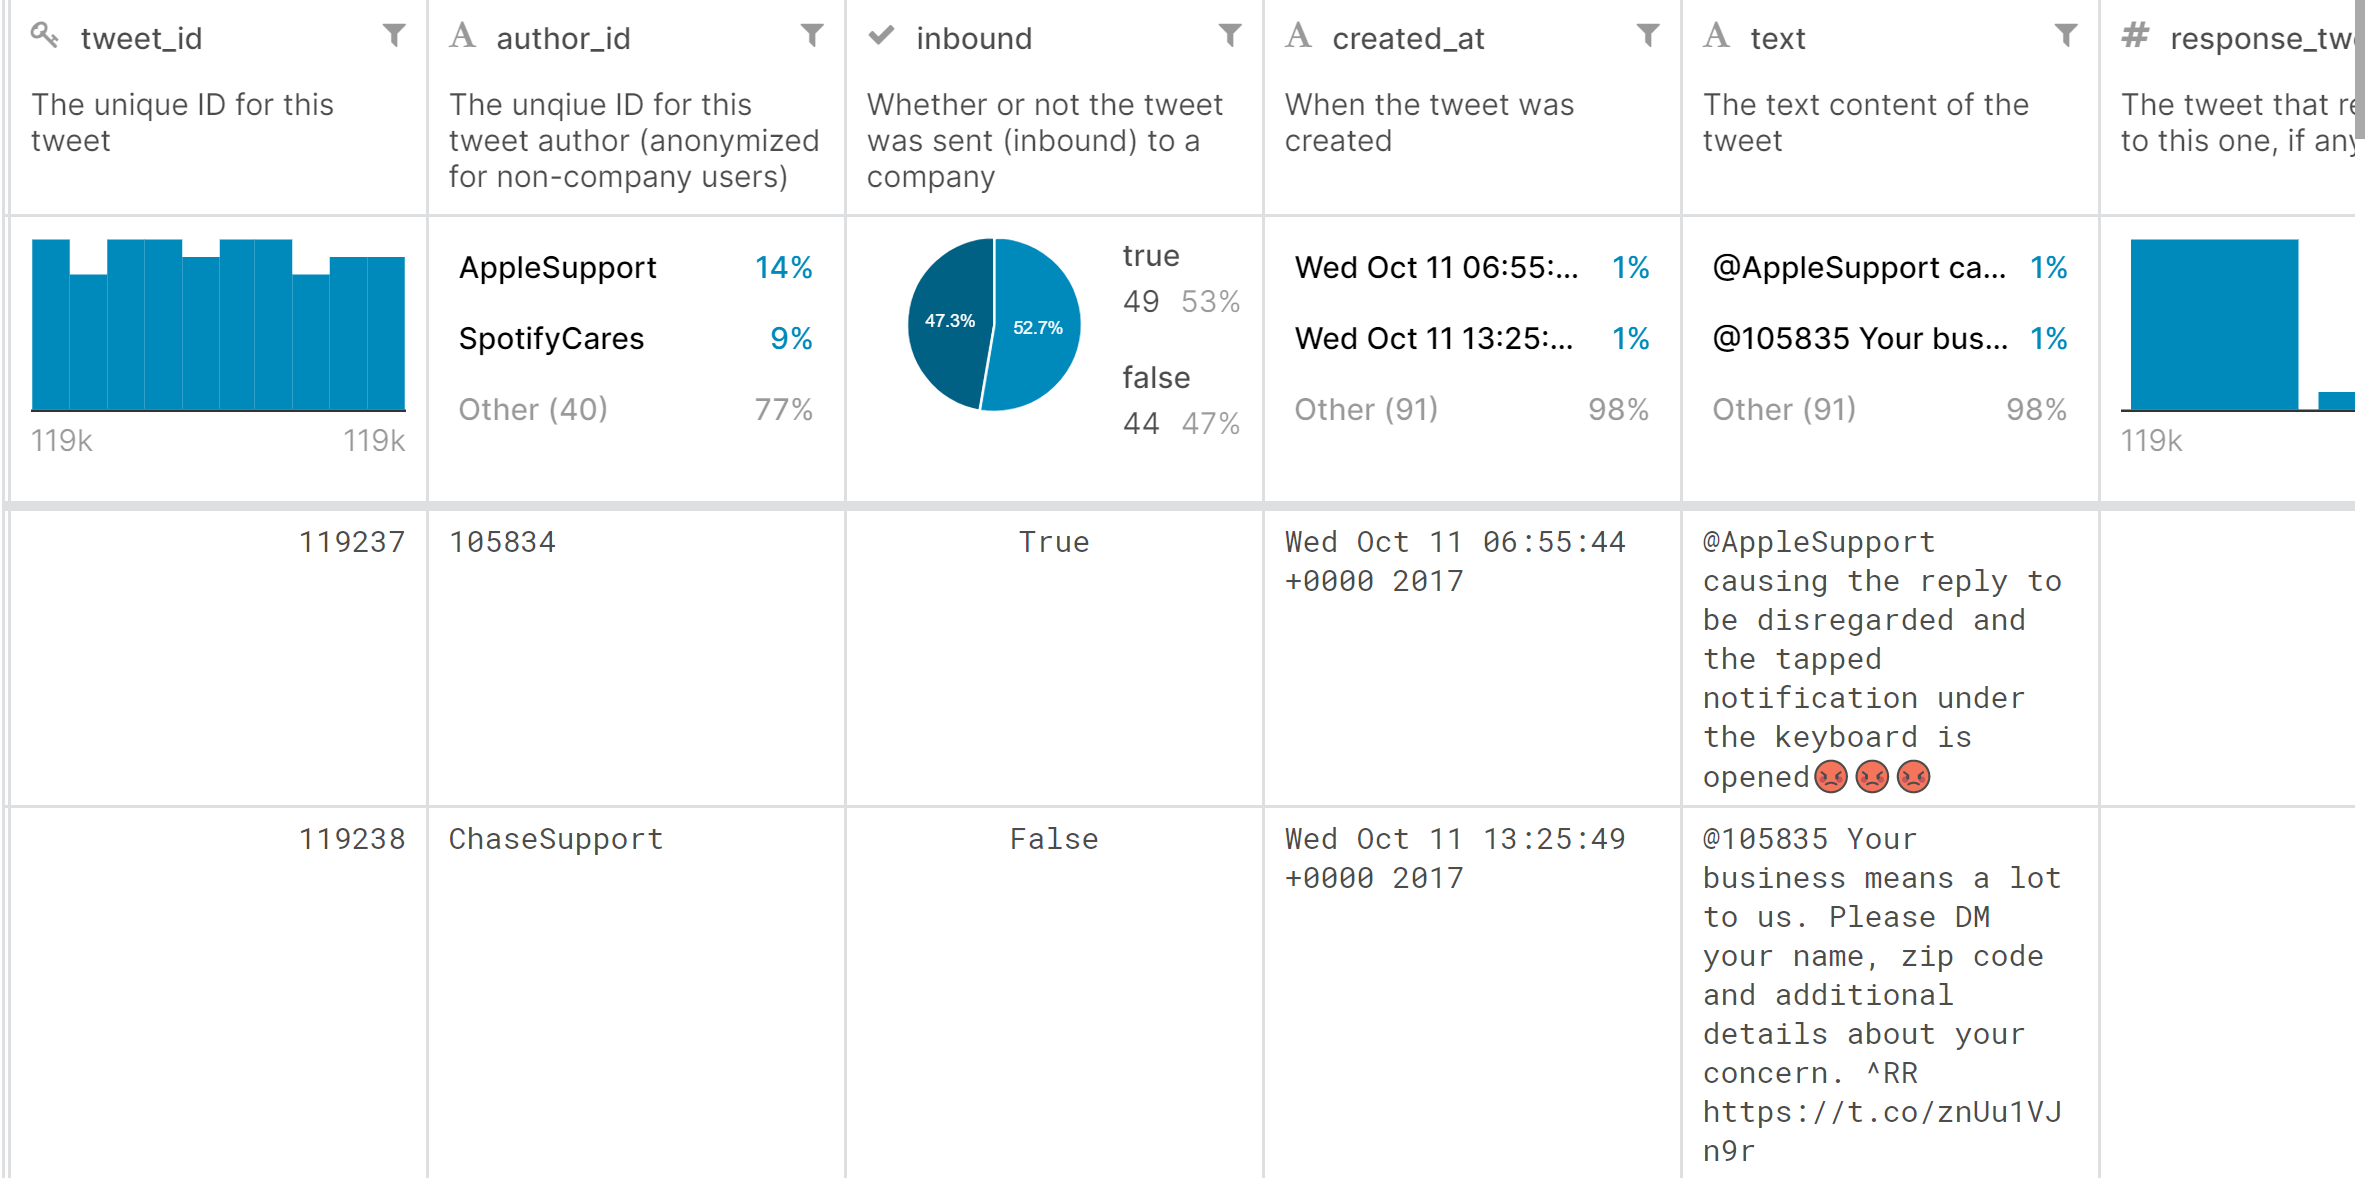

# **Twitter Filter Api for Collecting Hindi Tweets**

We are collecting tweets and replies from various Indian brands on twitter that offer support in Hindi.

In [0]:
import pandas as pd
import time
import tweepy as tw
class MyStreamListener(tw.StreamListener):

    def __init__(self):
        super(MyStreamListener,self).__init__()
        self.tweetText = []
        self.tweetScreenName = []
        self.tweetId = []
        self.replyName = []
        self.replyId = []
        self.count = 0
    def get_tweet_text(self,tweet):
        try:
            return tweet.extended_tweet['full_text']
        except AttributeError as e:
            return tweet.text
    def on_status(self, status):
        self.tweetText.append(self.get_tweet_text(status))
        self.tweetScreenName.append(status.user.screen_name)
        self.tweetId.append(status.id_str)
        self.replyName.append(status.in_reply_to_screen_name)
        self.replyId.append(status.in_reply_to_status_id)
        self.count += 1
        print(self.get_tweet_text(status))
        if self.count == 100:
            dataTemp=pd.DataFrame();
            dataTemp['TweetScreenName']=self.tweetScreenName
            dataTemp['TweetId']=self.tweetId
            dataTemp['UserName'] = self.replyName
            dataTemp['UserID'] = self.replyId
            dataTemp['TweetText']=self.tweetText
            timestr = time.strftime("%Y%m%d-%H%M%S")
            dataTemp.to_csv(timestr+' '+str(self.count)+'.csv',index=False)
            self.tweetText = []
            self.tweetScreenName = []
            self.tweetId = []
            self.replyName = []
            self.replyId = []
            self.count = 0
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_error disconnects the stream
            return False
        # returning non-False reconnects the stream, with backoff.

def start_stream(stream, **kwargs):
        try:
            stream.filter(**kwargs, languages = ['hi'])
        except Exception:
            print('except')

#KEYS HERE
consumer_key= ''
consumer_secret= ''
access_token= ''
access_token_secret= ''

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

realTimeTweets = []
myStreamListener = MyStreamListener()
myStream = tw.Stream(auth = api.auth, listener=myStreamListener, tweet_mode='extended')

#List of Customer Support handles (Food Delivery, Payment Applications, Airlines)
follow_list = {'@paytmcare': '2475273985','zomato' : "23283603", 'swiggy_in' :  "2639625036", 'UberINSupport' : "794125504357900289", 'olasupports' : "2542889478", 'swiggycares': "3286336254"}

start_stream(myStream,follow = list(follow_list.values()) ,is_async=True)

 **Sample Hindi Tweets:**

Actual Tweet:
Hindi:  @SwiggyCares कितना time और लगेगा कहीं तुम भी किसी फ्रॉड की तयारी तो नही कर रहे हो?

*(a transcription into Latin script)*
	
 @SwiggyCares Kitna time aur lagega kahin tum bhi kisi fraud ki tyari to nhi kar rahe ho?

*(a translation into English)*
@SwiggyCares How much time will it take, are you also preparing any fraud?




# **Data Processing for English Tweets**

Tweets are processed to remove URLs, Emoticons, UserNames and Hashtags. Customer tweets and it's corresponding company responses are collected together for training the model.

**Collecting and grouping customer tweets with the responses from company for each industry - Airlines, E-commerce, Tech**

In [0]:
import numpy as np 
import pandas as pd 
import re
import math
import unicodedata
from  unidecode import unidecode

def main():
	df = pd.read_csv("twcs.csv")
	print(list(df.columns))
	data_numpy = df.to_numpy()
	customer_service = {}
	# print(df["inbound"])
	tweet_dic = {}

	q_and_a = []
	Question_answer = []
	and_below = False
	for line in data_numpy:
		cleaned_text_at = re.sub(r'@[A-Z_a-z0-9]+','',line[4])
		cleaned_text_ulr = re.sub('https?://[A-Za-z0-9./]+','',cleaned_text_at)
		cleaned_text = deEmojify(cleaned_text_ulr)
		tweet_dic[line[0]] = cleaned_text

		if(is_company(line[1])):
			if(is_airline(line[1])):
				and_below = True
			else:
				and_below = False 
		else:
			if(and_below and line[2]):
				q_and_a.append((line[0],line[5]))


	for pair in q_and_a:
		Q = pair[0]
		A = ""
		if(isinstance(pair[1],float)):
			continue
		answer = pair[1].split(",")
		if(len(answer)>1):
			for a in answer:
				if(int(a) in tweet_dic):
					A+=tweet_dic[int(a)]+"||"
		else:
			if(int(answer[0]) in tweet_dic):
				A+= tweet_dic[int(answer[0])]+"||"
		Question_answer.append((tweet_dic[int(Q)],A))
	write_result(Question_answer)
 
def is_company(author_id):
	return not author_id.isdigit()
 
def is_airline(author_id):
	if(author_id in {"Delta":1,"AmericanAir":1,"British_Airways":1,"SouthwestAir":1}):
		return True
	else:
		return False

Collect the tweets and responses in Question - Answer type format 

In [0]:
def write_result(Question_answer):
	with open("tw_Q&A.txt","w",encoding="utf8") as file:
		for conversation in Question_answer:
			# file.write(conversation[0]+"\n")
			# file.write(conversation[1]+"\n")
			file.write(conversation[0]+"//"+conversation[1])
			file.write("\n")
main()


Remove Emoticons from the tweets 

In [0]:
def removeEmoticons (inputString):
    returnString = ""

    for character in inputString:
        try:
            character.encode("ascii")
            returnString += character
        except UnicodeEncodeError:
            replaced = unidecode(str(character))
            if replaced != '':
                returnString += replaced
            else:
                try:
                     returnString += "[" + unicodedata.name(character) + "]"
                except ValueError:
                     returnString += "[x]"

    return returnString

Remove Emojis from tweets 

In [0]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

Remove URLs 

In [0]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

Sample Data

In [0]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None

full_df = pd.read_csv("/content/drive/My Drive/NLP CSCI 544 Project/code/twcs.csv", nrows=50000)
df = full_df[["text"]]
df["text"] = df["text"].astype(str)
full_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


# **Sentiment Analysis for English Tweets**

Sentiment Analysis of customer tweets to 6 airlines in the United States - data has been accumalted from subset of Customer Support Dataset in which each tweet is classified as either **positive, negative, or neutral**. 

These tweets are annotated by crowdsourcing as mentioned in the kaggle dataset. If the tweet was classified as negative, there is a negative reason associated with this.We are evaluating various performance of analysis on this data in order to incorporate the most pertinent and accurate aspects into our project for sentiment analysis. 


Sentiment of the tweets will be incorporated in the model to generate better responses.

Source:  https://www.kaggle.com/crowdflower/twitter-airline-sentiment



In [0]:
root = '/content/gdrive/My Drive/NLP CSCI 544 Project/code/'
file = 'Tweets.csv'

In [0]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords


full_df = pd.read_csv(root+file,nrows=50000)

In [0]:
(full_df.head())

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
(len(full_df)-full_df.count())/len(full_df)

tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

In [0]:
del full_df['tweet_coord']
del full_df['airline_sentiment_gold']
del full_df['negativereason_gold']
sentiment_count = full_df['airline_sentiment'].value_counts()

In [0]:
print(sentiment_count)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


Text(0.5, 1.0, 'count of sentiments')

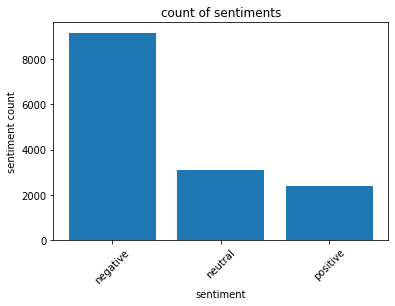

In [0]:
xaxis = [1,2,3]

plt.bar(xaxis,sentiment_count)
plt.xticks(xaxis,['negative','neutral','positive'],rotation=45)
plt.ylabel('sentiment count')
plt.xlabel('sentiment')
plt.title('count of sentiments')

In [0]:
def tokenize_tweets(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

In [0]:
def tweet_length(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 

In [0]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download("popular")

In [0]:
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(full_df):
    only_letters = re.sub("[^a-zA-Z]", " ",full_df) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

pd.set_option('display.max_colwidth', -1) 
full_df['normalized_tweet'] = full_df.text.apply(normalizer)
full_df[['text','normalized_tweet']].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


,text,normalized_tweet
0,@VirginAmerica What @dhepburn said.,"[dhepburn, said]"
1,@VirginAmerica plus you've added commercials to the experience... tacky.,"[added, commercial, experience, tacky]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[today, must, mean, need, take, another, trip]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, recourse]"
4,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]"


In [0]:
from nltk import ngrams

def ngrams(input_list):
    
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams

full_df['grams'] = full_df.normalized_tweet.apply(ngrams)
full_df[['grams']].head()


,grams
0,[dhepburn said]
1,"[added commercial, commercial experience, experience tacky, added commercial experience, commercial experience tacky]"
2,"[today must, must mean, mean need, need take, take another, another trip, today must mean, must mean need, mean need take, need take another, take another trip]"
3,"[really aggressive, aggressive blast, blast obnoxious, obnoxious entertainment, entertainment guest, guest face, face amp, amp little, little recourse, really aggressive blast, aggressive blast obnoxious, blast obnoxious entertainment, obnoxious entertainment guest, entertainment guest face, guest face amp, face amp little, amp little recourse]"
4,"[really big, big bad, bad thing, really big bad, big bad thing]"


In [0]:
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

vectorized_data = count_vectorizer.fit_transform(full_df.text)

indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]
targets = full_df.airline_sentiment.apply(sentiment2target)

In [0]:
from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
SVM_CLASSIFIER = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))



In [0]:
SVM_OUTPUT = SVM_CLASSIFIER.fit(data_train, targets_train)

In [0]:
SVM_OUTPUT.score(data_test, targets_test)

0.7851775956284153

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rff = OneVsRestClassifier(rf)
#print(rff)

In [0]:
RF_CLASSIFIER = rff.fit(data_train, targets_train)

In [0]:
RF_CLASSIFIER.score(data_test, targets_test)

0.757172131147541

# Seq-Seq Model for Text Generation - Baseline Model without Sentiment Analysis

# Basic Seq2Seq
seq2seq model implementation using keras, Tensorflow to predict company responses to consumers. 

Source:
https://github.com/google/seq2seq

![seq2seq model architecture](https://i.imgur.com/JmuryKu.png)

In [0]:
import re
import random
import time

print('Library versions:')

import keras
print(f'keras:{keras.__version__}')
import pandas as pd
print(f'pandas:{pd.__version__}')
import sklearn
print(f'sklearn:{sklearn.__version__}')
import nltk
print(f'nltk:{nltk.__version__}')
import numpy as np
print(f'numpy:{np.__version__}')

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import casual_tokenize

from tqdm import tqdm_notebook as tqdm # Special jupyter notebook progress bar 💫

## Model Parameters

In [0]:
MAX_VOCAB_SIZE = 2**13  # 8192
MAX_MESSAGE_LEN = 30  
# Embedding size for words 
EMBEDDING_SIZE = 100
CONTEXT_SIZE = 100
BATCH_SIZE = 4
DROPOUT = 0.2

LEARNING_RATE=0.005
# Tokens needed for seq2seq
UNK = 0  # words that aren't found in the vocab
PAD = 1  # after message has finished, this fills all remaining vector positions
START = 2  # provided to the model at position 0 for every response predicted
SUB_BATCH_SIZE = 1000


## Data Prep
Here, we'll prepare the data for training our seq2seq model, including:

- Replace screen names with `@__sn__` token to show model the commonality between them
- Build a vocab to turn tokens into integers suitable for our seq2seq model
- Tokenize input and target text into fixed size vectors
- Partition our dataset into train and test sets

### Data Loading and Reshaping


In [0]:
tweets = pd.read_csv('/content/drive/My Drive/NLP CSCI 544 Project/code/twcs.csv')

first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]

inbounds_and_outbounds = pd.merge(first_inbound, tweets, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id').sample(frac=1)

# Filter to only outbound replies (from companies)
inbounds_and_outbounds = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]

tqdm().pandas()  # Enable tracking of progress in dataframe `apply` calls

In [0]:
print(f'Data shape: {inbounds_and_outbounds.shape}')

Data shape: (794299, 14)


### Tokenizing and Vocab Build

 NLTK's `casual_tokenize`, which handles a lot of corner cases found in social media data ("casual" text data) along with scitkit learn's `CountVectorizer`.  

In [0]:
# Replace anonymized screen names with common token @__sn__
def sn_replace(match):
    _sn = match.group(2).lower()
    if not _sn.isnumeric():
        # This is a company screen name
        return match.group(1) + match.group(2)
    return '@__sn__'

sn_re = re.compile('(\W@|^@)([a-zA-Z0-9_]+)')
print("Replacing anonymized screen names in X...")
x_text = inbounds_and_outbounds.text_x.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))
print("Replacing anonymized screen names in Y...")
y_text = inbounds_and_outbounds.text_y.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))

Replacing anonymized screen names in X...




Replacing anonymized screen names in Y...


In [0]:
count_vec = CountVectorizer(tokenizer=casual_tokenize, max_features=MAX_VOCAB_SIZE - 3)
print("Fitting CountVectorizer on X and Y text data...")
count_vec.fit(tqdm(x_text + y_text))
analyzer = count_vec.build_analyzer()
vocab = {k: v + 3 for k, v in count_vec.vocabulary_.items()}
vocab['__unk__'] = UNK
vocab['__pad__'] = PAD
vocab['__start__'] = START
# Used to turn seq2seq predictions into human readable strings
reverse_vocab = {v: k for k, v in vocab.items()}
print(f"Learned vocab of {len(vocab)} items.")

Fitting CountVectorizer on X and Y text data...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"



Learned vocab of 8192 items.


### Vocab Helper Functions
These helper functions take strings and turn them into word indexes used by the actual seq2seq models.   apply the `to_word_idx` function to our text data to get our `N x MESSAGE_LEN` training/test data.

In [0]:
def to_word_idx(sentence):
    full_length = [vocab.get(tok, UNK) for tok in analyzer(sentence)] + [PAD] * MAX_MESSAGE_LEN
    return full_length[:MAX_MESSAGE_LEN]

def from_word_idx(word_idxs):
    return ' '.join(reverse_vocab[idx] for idx in word_idxs if idx != PAD).strip()


In [0]:
x_text.head().apply(to_word_idx).apply(from_word_idx)

4698         @idea_cares still no help about this . __unk__
446262    @__sn__ why can ’ t we get answers on transact...
241783    @delta 2nd time in 3 weeks you delayed / cance...
311567    @__sn__ __unk__ __unk__ __unk__ & __unk__ gin ...
833432    @jetblue for the last 3 days i get __unk__ whe...
Name: text_x, dtype: object

In [0]:
print("Calculating word indexes for X...")
x = pd.np.vstack(x_text.progress_apply(to_word_idx).values)
print("Calculating word indexes for Y...")
y = pd.np.vstack(y_text.progress_apply(to_word_idx).values)

Calculating word indexes for X...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  



Calculating word indexes for Y...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.


### Train / Test Split
Here, we split our data into training and test sets.  80-20 split for train-test

In [0]:
all_idx = list(range(len(x)))
train_idx = set(random.sample(all_idx, int(0.8 * len(all_idx))))
test_idx = {idx for idx in all_idx if idx not in train_idx}

train_x = x[list(train_idx)]
test_x = x[list(test_idx)]
train_y = y[list(train_idx)]
test_y = y[list(test_idx)]

assert train_x.shape == train_y.shape
assert test_x.shape == test_y.shape

print(f'Training data of shape {train_x.shape} and test data of shape {test_x.shape}.')

Training data of shape (635439, 30) and test data of shape (158860, 30).


## Model Creation


- Shared word embeddings

- Encoder RNN
  
- Decoder RNN
  
- Next Word Dense+Softmax
  


In [0]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, LSTM, Dropout, Embedding, RepeatVector, concatenate, \
    TimeDistributed
from keras.utils import np_utils

In [0]:
def create_model():
    shared_embedding = Embedding(
        output_dim=EMBEDDING_SIZE,
        input_dim=MAX_VOCAB_SIZE,
        input_length=MAX_MESSAGE_LEN,
        name='embedding',
    )
    
    # ENCODER
    
    encoder_input = Input(
        shape=(MAX_MESSAGE_LEN,),
        dtype='int32',
        name='encoder_input',
    )
    
    embedded_input = shared_embedding(encoder_input)
    
    # No return_sequences - since the encoder here only produces a single value for the
    # input sequence provided.
    encoder_rnn = LSTM(
        CONTEXT_SIZE,
        name='encoder',
        dropout=DROPOUT
    )
    
    context = RepeatVector(MAX_MESSAGE_LEN)(encoder_rnn(embedded_input))
    
    # DECODER
    
    last_word_input = Input(
        shape=(MAX_MESSAGE_LEN, ),
        dtype='int32',
        name='last_word_input',
    )
    
    embedded_last_word = shared_embedding(last_word_input)
    # Combines the context produced by the encoder and the last word uttered as inputs
    # to the decoder.
    decoder_input = concatenate([embedded_last_word, context], axis=2)
    
    # return_sequences causes LSTM to produce one output per timestep instead of one at the
    # end of the intput, which is important for sequence producing models.
    decoder_rnn = LSTM(
        CONTEXT_SIZE,
        name='decoder',
        return_sequences=True,
        dropout=DROPOUT
    )
    
    decoder_output = decoder_rnn(decoder_input)
    
    # TimeDistributed allows the dense layer to be applied to each decoder output per timestep
    next_word_dense = TimeDistributed(
        Dense(int(MAX_VOCAB_SIZE / 2), activation='relu'),
        name='next_word_dense',
    )(decoder_output)
    
    next_word = TimeDistributed(
        Dense(MAX_VOCAB_SIZE, activation='softmax'),
        name='next_word_softmax'
    )(next_word_dense)
    
    return Model(inputs=[encoder_input, last_word_input], outputs=[next_word])

s2s_model = create_model()
optimizer = Adam(lr=LEARNING_RATE, clipvalue=5.0)
s2s_model.compile(optimizer='adam', loss='categorical_crossentropy')

## Model Training


In [0]:
def add_start_token(y_array):
    """ Adds the start token to vectors.  Used for training data. """
    return np.hstack([
        START * np.ones((len(y_array), 1)),
        y_array[:, :-1],
    ])

def binarize_labels(labels):
    """ Helper function that turns integer word indexes into sparse binary matrices for 
        the expected model output.
    """
    return np.array([np_utils.to_categorical(row, num_classes=MAX_VOCAB_SIZE)
                     for row in labels])

In [0]:
def respond_to(model, text):
    """ Helper function that takes a text input and provides a text output. """
    input_y = add_start_token(PAD * np.ones((1, MAX_MESSAGE_LEN)))
    idxs = np.array(to_word_idx(text)).reshape((1, MAX_MESSAGE_LEN))
    for position in range(MAX_MESSAGE_LEN - 1):
        prediction = model.predict([idxs, input_y]).argmax(axis=2)[0]
        input_y[:,position + 1] = prediction[position]
    return from_word_idx(model.predict([idxs, input_y]).argmax(axis=2)[0])

In [0]:
def train_mini_epoch(model, start_idx, end_idx):

    b_train_y = binarize_labels(train_y[start_idx:end_idx])
    input_train_y = add_start_token(train_y[start_idx:end_idx])
    
    model.fit(
        [train_x[start_idx:end_idx], input_train_y], 
        b_train_y,
        epochs=1,
        batch_size=BATCH_SIZE,
    )
    
    rand_idx = random.sample(list(range(len(test_x))), SUB_BATCH_SIZE)
    print('Test results:', model.evaluate(
        [test_x[rand_idx], add_start_token(test_y[rand_idx])],
        binarize_labels(test_y[rand_idx])
    ))
    
    input_strings = [
        "@AppleSupport I fix I this I stupid I problem I",
        "@AmazonHelp I hadnt expected that such a big brand like amazon would have such a poor customer service.",
    ]
    
    for input_string in input_strings:
        output_string = respond_to(model, input_string)
        print(f'> "{input_string}"\n< "{output_string}"')


### Train the model!


In [0]:
training_time_limit = 360 * 60  # seconds (notebooks terminate after 1 hour)
start_time = time.time()
stop_after = start_time + training_time_limit

class TimesUpInterrupt(Exception):
    pass

try:
    for epoch in range(100):
        print(f'Training in epoch {epoch}...')
        for start_idx in range(0, len(train_x), SUB_BATCH_SIZE):
            train_mini_epoch(s2s_model, start_idx, start_idx + SUB_BATCH_SIZE)
            if time.time() > stop_after:
                raise TimesUpInterrupt
except KeyboardInterrupt:
    print("Halting training from keyboard interrupt.")
except TimesUpInterrupt:
    print(f"Halting after {time.time() - start_time} seconds spent training.")

Training in epoch 0...
Epoch 1/1
1000/1000 [==============================] - 100s 100ms/step
Test results: 4.230677749633789
> "@AppleSupport I fix I this I stupid I problem I"
< "@__sn__ hi , , , , , , , , , , . ."
> "@AmazonHelp I hadnt expected that such a big brand like amazon would have such a poor customer service."
< "@__sn__ hi , , , , , , , , , , . ."
Epoch 1/1
1000/1000 [==============================] - 100s 100ms/step
Test results: 3.844701509475708
> "@AppleSupport I fix I this I stupid I problem I"
< "@__sn__ hi , sorry to hear to hear to the __unk__ . __unk__ . __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__"
> "@AmazonHelp I hadnt expected that such a big brand like amazon would have such a poor customer service."
< "@__sn__ hi , sorry to hear to hear to hear to the __unk__ . __unk__ . __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __unk__ __

In [0]:
respond_to(s2s_model, '''@AppleSupport iPhone 8 touchID doesnt unlock while charging on 
    110v w/ 61w laptop charger to usbc lightning cable just uh.. so you guys know''')

"@__sn__ hi , __unk__ . we are sorry to hear this . please dm us your idea number and we'll be happy to help you . ^ __unk__"

In [0]:
# serialize model to JSON
model_json = s2s_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
s2s_model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# **Future Work**


*   Separate positive, negative tweets for Customizable Text generation model
*   Implement Transformer model for text generation
*   Apply Topic Modelling for to get more classifications 
*   Model the text generation model on Collected Hindi Tweets Corpus with pre-trained Hind2Vec Language models
*   Evaluation: Greedy Matching, embedding average methods to match with human response 





